In [ ]:
!pip install scikit-learn --upgrade



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!pip install imbalanced-learn --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 6.1 MB/s eta 0:00:00


# Import Packages

In [ ]:
%config Completer.use_jedi = False

import os
import random
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.image as mpimg

from PIL import Image
import imageio
import cv2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dense, Dropout, Activation, Flatten
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img


In [2]:
directory = r'Data/The IQ-OTHNCCD lung cancer dataset'
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

La variable **categories** est une liste qui représente les différentes classes d'images présentes dans le dataset.


1.   Benign cases : Cas où les tumeurs, si elles existent, sont bénignes et non cancéreuses.
2.   Malignant cases : Cas de tumeurs malignes qui sont cancéreuses.
3. Normal cases : Représente des radiographies pulmonaires qui ne montrent aucune anomalie ou tumeur.




In [ ]:
directory = r'/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset'

categories = ['Benign cases', 'Malignant cases', 'Normal cases']

# Image Size Variations

Avant de pouvoir analyser et classifier les images, il est nécessaire de connaître leurs dimensions au préalable.

Dans le code ci-dessous, on liste, pour chaque catégorie, les dimensions associées au nombre d'occurrence.

La fonction ```imageio.imread``` permet de lire l'image.

La propriété ```shape``` sert à obtenir les dimensions (hauteur, largeur, canaux - *nombre de couches utilisées pour coder un pixel de l'image*)

In [ ]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

size_data

<ipython-input-4-3269ec0e3dbe>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 801': 28,
  '404 x 511': 1,
  '512 x 623': 31},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Afin d'avoir une référence pour chaque cas et visualiser les différentes caractéristiques, on affiche une image de chaque catégorie.

Pour cela, on utilise la librairie **opencv-python (cv2)** dédiée au traitement d'images.

La fonction ```imread``` permet de lire l'image donnée en paramètre.

Le deuxième argument a pour but de définir la manière de lire l'image :

- 1 (par défaut) : image en couleur sans transparence
- 0 : image en niveau de gris
- -1 : image en couleur avec transparence

L'image rendue étant en niveau de gris, les données sont stockées dans une matrice 2D. Or, selon la [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) la fonction ```imshow``` de matplotlib, lorsqu'elle reçoit des données 2D, affiche une image en fausses couleurs.

C'est pourquoi les images que nous observerons tendront vers le vert.

Bengin cases


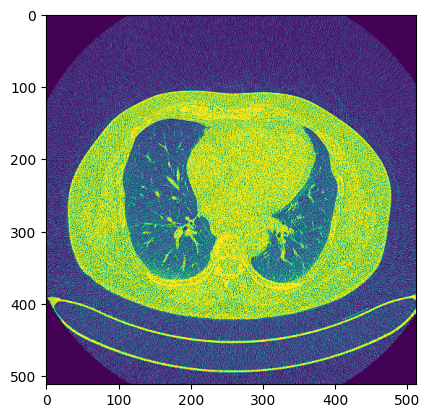

Malignant cases


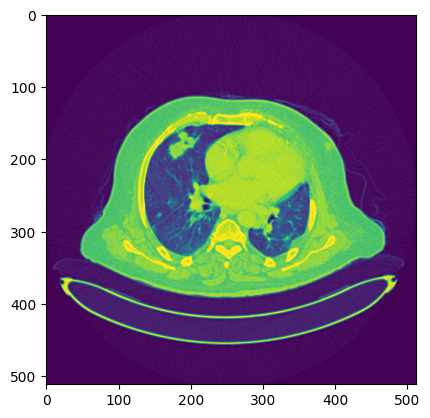

Normal cases


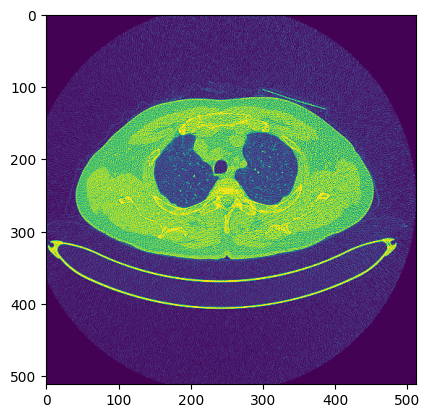

In [ ]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

# Image Preprocessing and Testing

 Pour chaque catégorie, il y aura 3 images affichées (les originales et leurs variantes) sur 3 colonnes. C'est la condition suivante qui permet d'interrompre l'affichage si le nombre d'images traitées atteint la limite défini par la variable **samples** (3 dans ce cas).
```python
if cnt == samples:
    break
```

 La taille de la figure est définie à 15x15 et le titre de la figure est défini comme la catégorie en cours d'analyse.

 Pour chaque fichier d'image :
- L'image est lue en niveau de gris
```python
img = cv2.imread(filepath, 0)
```
- L'image est redimensionnée à la taille de 256x256 pixels
- Un flou gaussien est appliqué à l'image redimensionnée pour améliorer la lisibilité de l'image en reduisant le bruit.
```python
img1 = cv2.GaussianBlur(img0, (5, 5), 0)
```





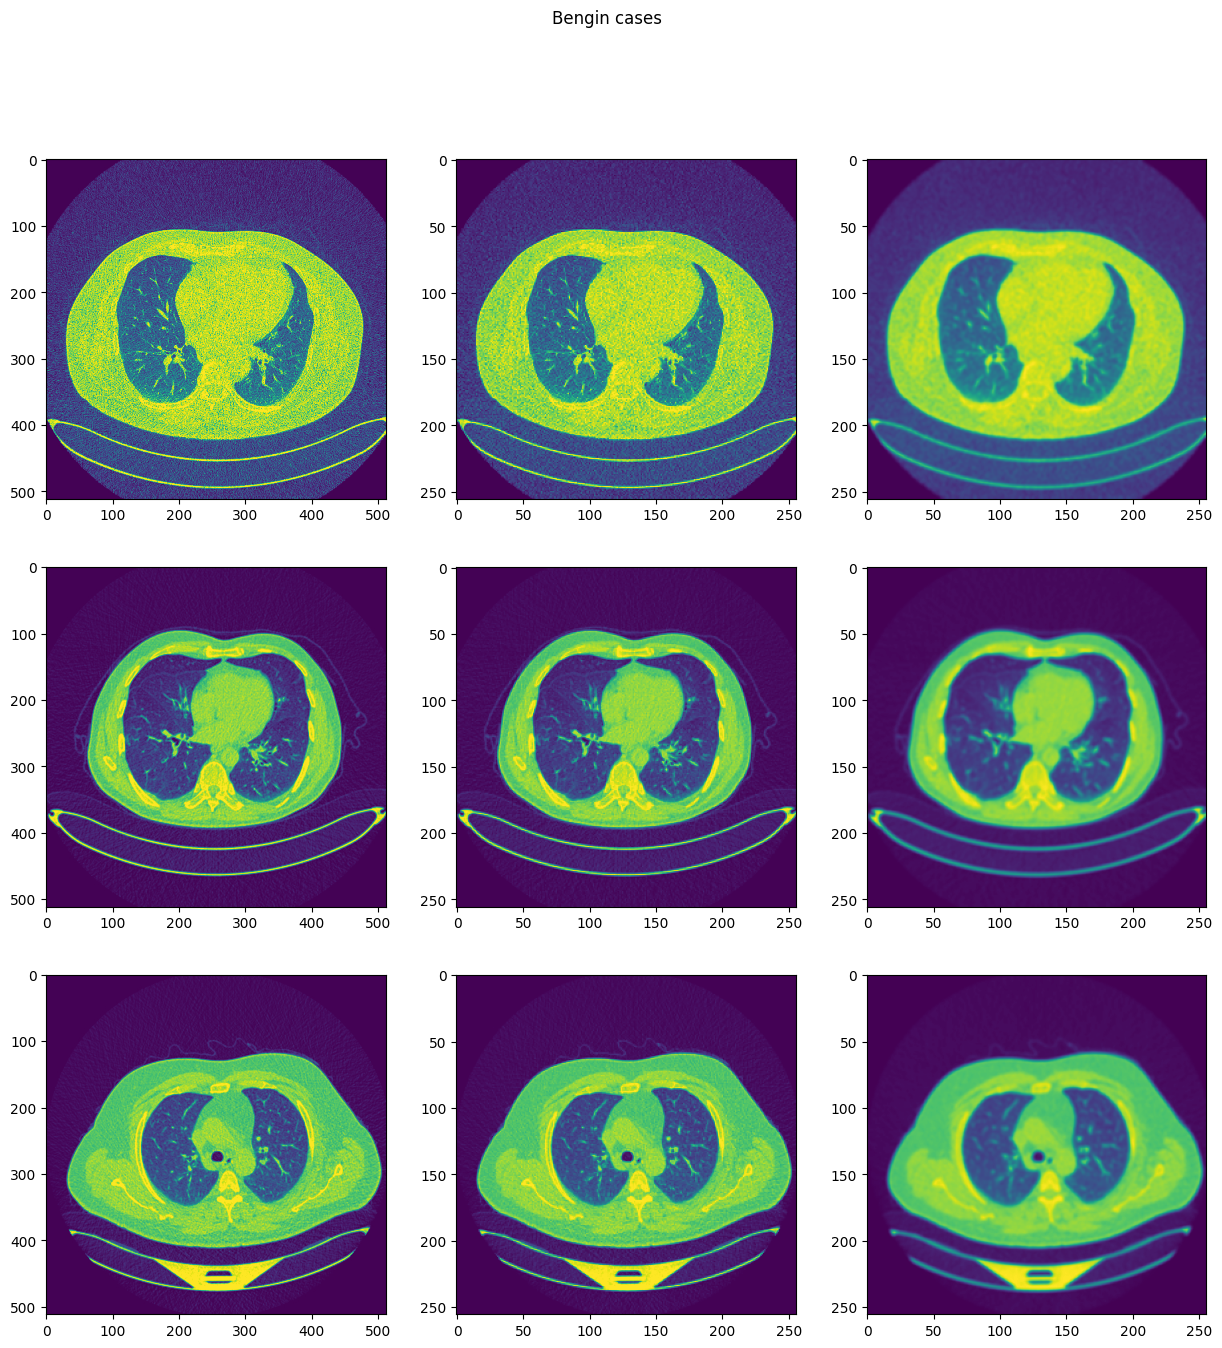

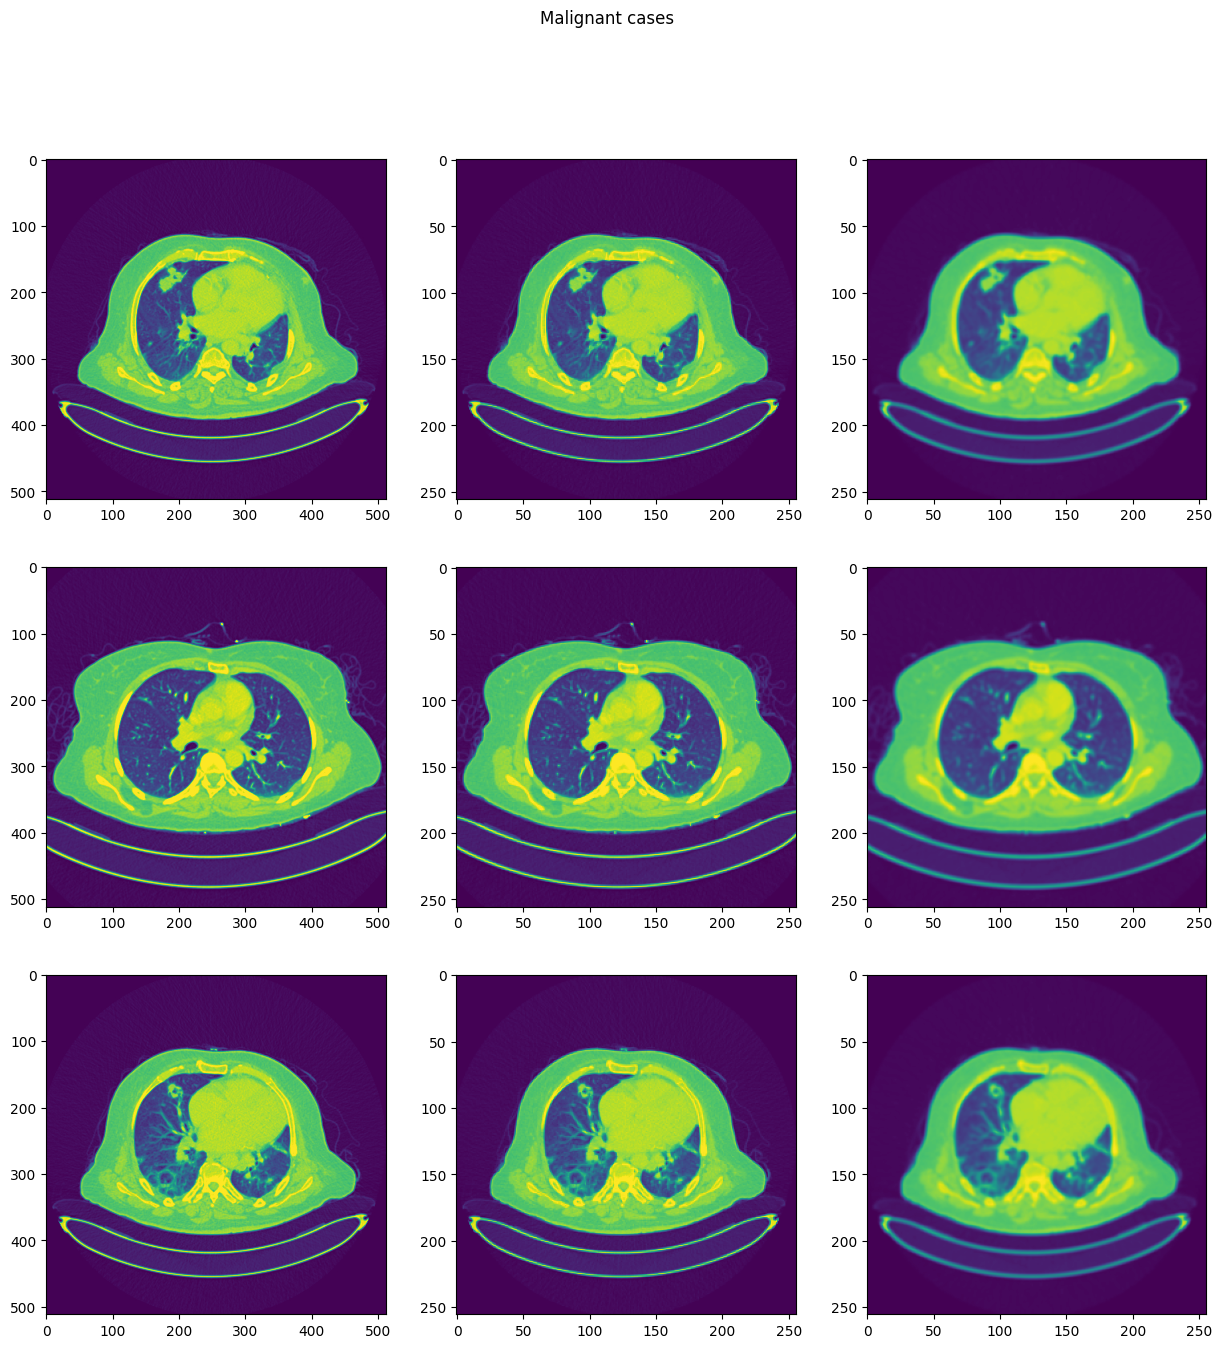

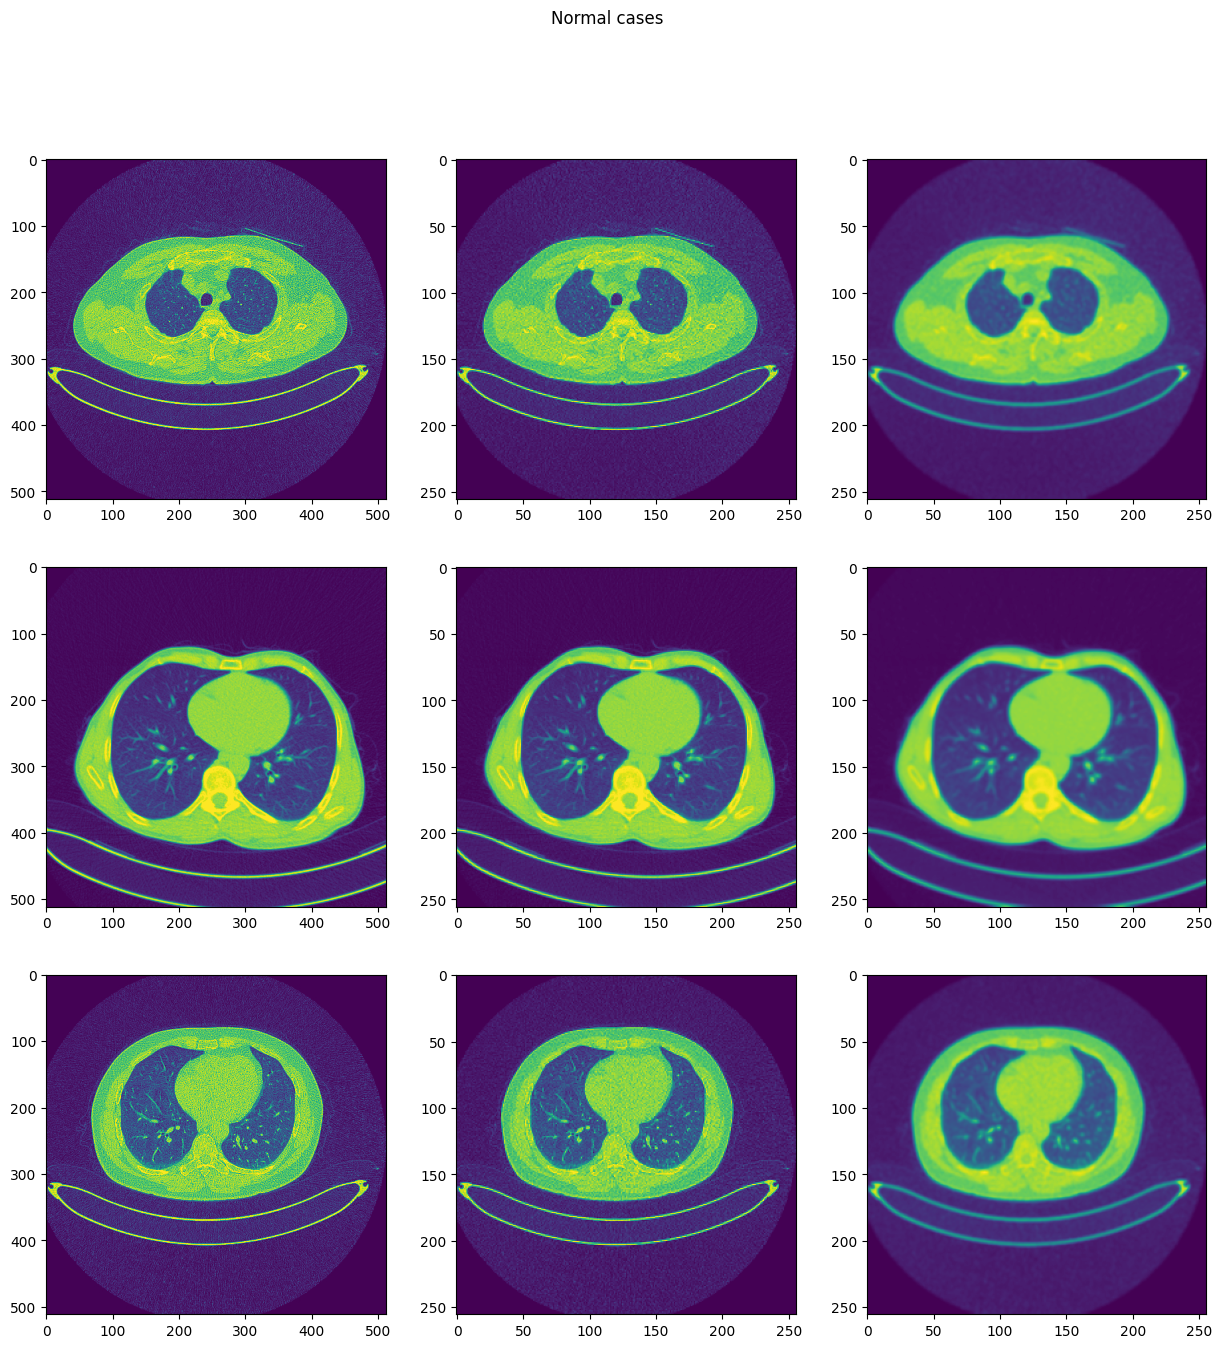

In [ ]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)

        img0 = cv2.resize(img, (img_size, img_size))

        img1 = cv2.GaussianBlur(img0, (5, 5), 0)

        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break

plt.show()

# Preparing Data

Le tableau **data** est initialisé pour contenir les différentes images et leurs lables.
Un numéro de classe est attribué à chaque catégorie d'images (benign, malignant et normal). Les images sont encore une fois lues en niveaux de gris afin de simplifier l'analyse (moins d'information par rapport à une image en couleur). En effet, dans le cas de la détection du cancer, la couleur peut ne pas apporter d'informations supplémentaires significatives.


Les données sont ensuite mélangées à l'aide de la méthode **data.shuffle** pour assurer une distribution aléatoire des données lors de l'entrainement. Cela est nécessaire parce que si toutes les images d'une certaine catégorie sont regroupées, le modèle d'apprentissage pourrait mal performer lors des premieres étapes d'entrainement. Le modèle pourrait être temporairement biaisé vers cette catégorie jusqu'à ce qu'il voit d'autres catégories. Ce problème peut alors conduire le modèle vers un minimum local ou ralentir sa convergence durant l'entrainement.


Les images et les labels sont ensuite séparés en deux listes distinctes X et Y afin de distinguer les entrées (images) et les sorties (labels). Nous avons affaire ici à une méthode d'apprentissage supervisé, ainsi :     


*   X (caractéristiques) : Ce sont les entrées utilisées par le modèle pour faire ses prédictions. Ici, il s'agit des images.
*   Y (labels) : Ce sont les valeurs que le modèle tente de prédire. Ici il s'agit des catégories d'images (benign, malignant ou normal)


Enfin, les images sont converties en tableaux numpy et normalisées. Les valeurs des pixels d'une image varient normalement de 0 à 255. En les normalisant entre 0 et 1, les calculs se retrouvent facilités pour la phase d'entrainement du modèle.



In [ ]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


Les données sont divisées en ensembles d'entrainement et de validation en utilisant la méthode ```train_test_split()``` : elle décompose de manière aléatoire un ensemble de données. Une partie servira à l'entrainement du modèle et l'autre permettra de le tester pour la validation. L'utilisation de ```stratify=y``` s'assure que la distribution des labels dans les ensembles d'entraînement et de validation est similaire à celle de l'ensemble de données original. C'est essentiel pour garantir que l'ensemble de validation est représentatif de l'ensemble de données global.

La division des données en ensembles d'entrainement et de validation est nécessaire car si un modèle est uniquement formé et évalué sur le même ensemble de données, il peut mémoriser ces données (surapprentissage) et mal performer sur de nouvelles données. En ayant un ensemble de validation distinct, on peut obtenir une estimation plus réaliste de la performance du modèle sur des données nouvelles.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


# Applying SMOTE to oversample the data

Comme nous pouvons le constater dans la cellule ci-dessous, les données dont nous disposons ne sont pas réparties de manière équilibrée, que cela soit pour l'ensemble d'entraînement ou bien de validaton.

Par exemple, pour l'ensemble d'entraînement, on compte 420 images de cancer de type bénin *(1)*, 312 de type malin *(2)* et 90 considérés comme normaux *(0)*.

Ce déséquilibre influence fortement les performances du modèle. En effet, le nombre d'images données est un facteur important car cela permet au modèle d'acquérir plus d'expériences et d'être plus familier avec la catégorie concernée. Ainsi, plus une catégorie contient d'images, mieux le modèle saura la reconnaître à l'avenir.


Afin de pallier ce problème, on utilise la technique *Synthetic Minority Oversampling Technique* ou **SMOTE** pour créer, à partir des données existantes, de nouvelles images pour les catégories minoritaires et ainsi rééquilibrer la balance.

In [ ]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


Afin de faciliter la création de nouvelles images par la méthode SMOTE, il est nécessaire de modifier la structure des images qui sont pour le moment codées dans des matrices 2D (dont les dimensions sont 256 x 256) pour obtenir au final un tableau à 1 dimension.

Pour cela, nous utilisons la méthode ``reshape`` de numpy.

In [ ]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


  Nous allons utiliser la classe ``SMOTE`` fournie par la librairie ``imbalanced-learn (imblearn)`` pour créer les données manquantes.

  La méthode ``fit_resample`` prend en entrée 2 tableaux :
  1. les données
  2. les labels correspondants

Elle retourne les 2 tableaux transformés.

On peut désormais observer que la matrice est équilibrée. Pour les catégories minoritaires, des images ont été artificellement créées à partir des images existantes pour combler la différence.

Ainsi, pour chaque catégorie, on compte **420** images.


In [ ]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [ ]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


# Model Building with SMOTE data

Les zones de forte probabilité prédites par le modèle sont à présent plus larges, et permettent de couvrir l’espace dans lequel se trouvent les données. Ainsi le point entouré en jaune se voit bien attribuer une probabilité élevée, alors qu’il était dans une zone de probabilité faible avec le premier modèle. Le modèle a une performance similaire sur les données avant smote et après : il a une faible variance.

Smote permet donc

On observe une re-équilibrage des données du 3 cas de figure.
Ci-dessous nous avons la comparons ces prédictions avec celles d’un modèle entraîné sur les données rééchantillonnées par le SMOTE :

In [ ]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dense(3, activation='softmax'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 activation_1 (Activation)   (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)           

Nous catégorisons les données une fois compilés, en même temps nous vérifions la précision.

In [ ]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Nous observons une nette amélioration et une précision considérable. Désormais l'algorithme le pourcentage d'erreur de l'algorithme est de 0.4 à 1.5% contre 40% précidemment. Cela confirme le fait que plus on a de données, plus la précision est grande.

In [ ]:
history = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
158/158 [==============================] - 241s 2s/step - loss: 0.5079 - accuracy: 0.8389 - val_loss: 0.0934 - val_accuracy: 0.9745
Epoch 2/10
158/158 [==============================] - 235s 1s/step - loss: 0.0431 - accuracy: 0.9929 - val_loss: 0.0346 - val_accuracy: 0.9891
Epoch 3/10
158/158 [==============================] - 243s 2s/step - loss: 0.0176 - accuracy: 0.9960 - val_loss: 0.0601 - val_accuracy: 0.9891
Epoch 4/10
158/158 [==============================] - 239s 2s/step - loss: 0.0239 - accuracy: 0.9952 - val_loss: 0.0366 - val_accuracy: 0.9855
Epoch 5/10
158/158 [==============================] - 238s 2s/step - loss: 0.0415 - accuracy: 0.9913 - val_loss: 0.0313 - val_accuracy: 0.9964
Epoch 6/10
158/158 [==============================] - 230s 1s/step - loss: 0.0145 - accuracy: 0.9968 - val_loss: 0.0624 - val_accuracy: 0.9891
Epoch 7/10
158/158 [==============================] - 235s 1s/step - loss: 0.0177 - accuracy: 0.9952 - val_loss: 0.0824 - val_accuracy: 0.9855

# Results

Pour mesurer la qualité des prédictions, on effectue un rapport de classification : combien de prédiction sont vraies et combien sont fausses. Plus précisemment, les *vrais positifs*, les *faux positifs*, les *vrais négatifs* et les *faux négatifs* sont utilisés pour prédire les mesures d'un rapport de classification.
Le rapport montre la précision des principales mesures de classification (precision), le rappel (recall) et le score f1 par classe (f1-score).


1.   La precision permet de connaitre le nombre de prédictions positifs bien effectuées. C'est le nombre de positifs bien prédit (vrai positif) divisé par l'ensemble des positifs prédit (vrai positif + faux positif)
> $precision = \frac{Vrai Positif}{Vrai Positif + Faux Positif}$


2.   Le recall est assez similaire a la precision : il permet de connaitre le pourcentage de positifs bien prédit par notre modèle. C'est le nombre de positifs bien prédit (vrai positif) divisé par l'ensemble des positifs (vrai positif + faux négatif)
> $recall = \frac{Vrai Positif}{Vrai Positif + Faux Négatif}$

  Ainsi, quand le recall est haut, cela veut dire que le modèle ne ratera aucun positif. Cependant cela ne donne aucune information sur la qualité de prédiction sur les négatifs.



In [ ]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 14s 1s/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       1.00      1.00      1.00       141
           2       0.99      1.00      1.00       104

    accuracy                           1.00       275
   macro avg       1.00      0.99      0.99       275
weighted avg       1.00      1.00      1.00       275

[[ 29   0   1]
 [  0 141   0]
 [  0   0 104]]


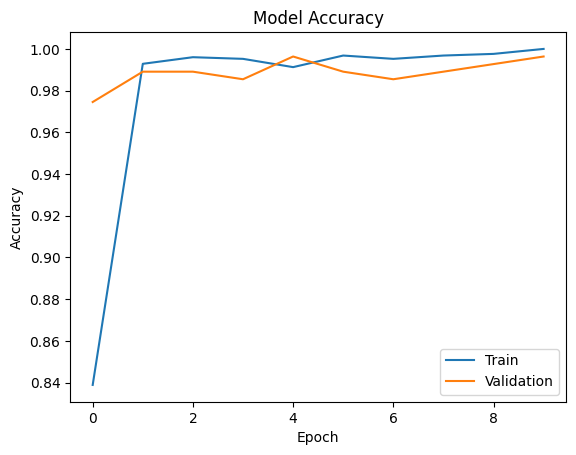

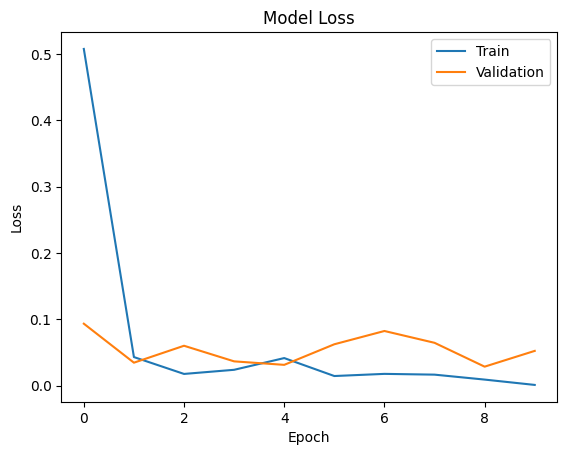

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model Building with Class Weighted Approach

In [ ]:
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(16))
model2.add(Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 activation_2 (Activation)   (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 246016)           

In [ ]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
new_weights = {
    0: X_train.shape[0]/(3*Counter(y_train)[0]),
    1: X_train.shape[0]/(3*Counter(y_train)[1]),
    2: X_train.shape[0]/(3*Counter(y_train)[2]),
}

# new_weights[0] = 0.5
# new_weights[1] = 20

new_weights

{0: 3.0444444444444443, 1: 0.6523809523809524, 2: 0.8782051282051282}

In [ ]:
history = model2.fit(X_train, y_train, batch_size=8, epochs=10, validation_data=(X_valid, y_valid), class_weight=new_weights)

Epoch 1/10
103/103 [==============================] - 162s 2s/step - loss: 0.7467 - accuracy: 0.7324 - val_loss: 0.2167 - val_accuracy: 0.9455
Epoch 2/10
103/103 [==============================] - 160s 2s/step - loss: 0.1083 - accuracy: 0.9769 - val_loss: 0.1431 - val_accuracy: 0.9818
Epoch 3/10
103/103 [==============================] - 150s 1s/step - loss: 0.0667 - accuracy: 0.9878 - val_loss: 0.0341 - val_accuracy: 0.9891
Epoch 4/10
103/103 [==============================] - 158s 2s/step - loss: 0.0213 - accuracy: 0.9951 - val_loss: 0.1488 - val_accuracy: 0.9818
Epoch 5/10
103/103 [==============================] - 158s 2s/step - loss: 0.0384 - accuracy: 0.9951 - val_loss: 0.0136 - val_accuracy: 0.9964
Epoch 6/10
103/103 [==============================] - 153s 1s/step - loss: 0.0146 - accuracy: 0.9964 - val_loss: 0.0646 - val_accuracy: 0.9745
Epoch 7/10
103/103 [==============================] - 157s 2s/step - loss: 0.0281 - accuracy: 0.9976 - val_loss: 0.1884 - val_accuracy: 0.9855

# Results

In [ ]:
y_pred = model2.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 12s 1s/step
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        30
           1       1.00      0.97      0.99       141
           2       1.00      0.88      0.93       104

    accuracy                           0.94       275
   macro avg       0.88      0.95      0.90       275
weighted avg       0.96      0.94      0.94       275

[[ 30   0   0]
 [  4 137   0]
 [ 13   0  91]]


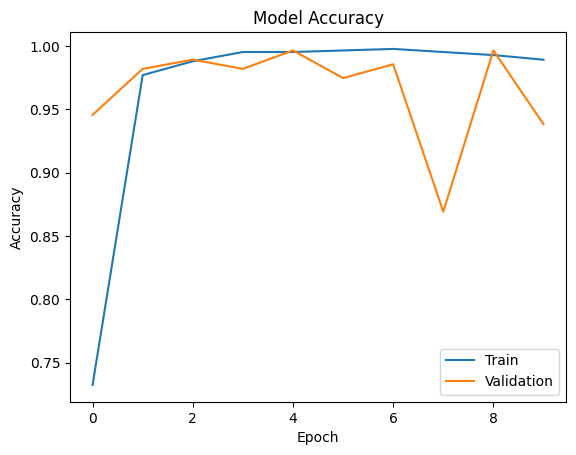

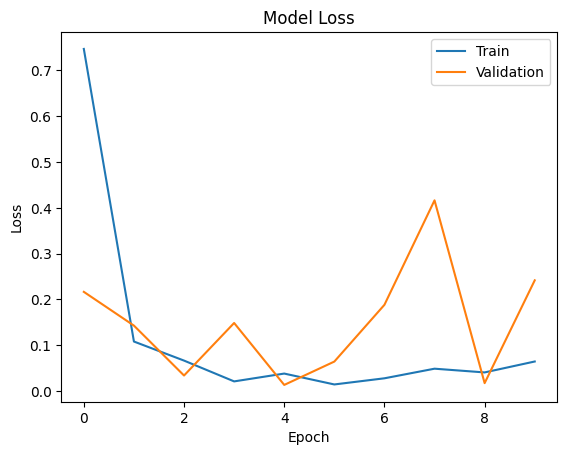

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=8)

In [ ]:
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(16))
model3.add(Dense(3, activation='softmax'))

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 activation_3 (Activation)   (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 246016)           

In [ ]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model3.fit_generator(train_generator, epochs=5, validation_data=val_generator, class_weight=new_weights)

Epoch 1/5


<ipython-input-34-6ec88e3e8198>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3.fit_generator(train_generator, epochs=5, validation_data=val_generator, class_weight=new_weights)


103/103 [==============================] - 163s 2s/step - loss: 1.3469 - accuracy: 0.5487 - val_loss: 0.9681 - val_accuracy: 0.6218
Epoch 2/5
103/103 [==============================] - 151s 1s/step - loss: 0.7268 - accuracy: 0.6971 - val_loss: 0.5978 - val_accuracy: 0.7636
Epoch 3/5
103/103 [==============================] - 197s 2s/step - loss: 0.4340 - accuracy: 0.8491 - val_loss: 0.4737 - val_accuracy: 0.7855
Epoch 4/5
103/103 [==============================] - 165s 2s/step - loss: 0.2792 - accuracy: 0.9015 - val_loss: 0.2533 - val_accuracy: 0.9091
Epoch 5/5
103/103 [==============================] - 170s 2s/step - loss: 0.1976 - accuracy: 0.9380 - val_loss: 0.1655 - val_accuracy: 0.9345


In [ ]:
y_pred = model3.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 14s 1s/step
              precision    recall  f1-score   support

           0       0.78      0.83      0.81        30
           1       1.00      0.92      0.96       141
           2       0.90      0.98      0.94       104

    accuracy                           0.93       275
   macro avg       0.89      0.91      0.90       275
weighted avg       0.94      0.93      0.94       275

[[ 25   0   5]
 [  5 130   6]
 [  2   0 102]]
